<a href="https://colab.research.google.com/github/MoreCookies/scifair23-24/blob/main/FastAI_scifair24_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import urllib.request
import zipfile


urls = {
    "train" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip",
    "train_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip",
    "validation" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip",
    "validation_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip",
    "test" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip",
    "test_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_GroundTruth.zip",
    #"train_seg": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip",
    #"train_seg_gt": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip",
    #"validation_seg": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip",
    #"validation_seg_gt": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip",
    "train_2019" : "https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip",
    "train_gt_2019" : "https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv"

}

def download_all():
    for item in urls.items():
        name = item[0]
        url = item[1]
        filename = f"{name}.csv"
        if not url.endswith(".csv"):
          filename = f"{name}.zip"
        if os.path.exists(filename):
            print(f"already exists file {filename}")
        else:
            print(f"downloading {filename} from {url} ...")
            urllib.request.urlretrieve(url, filename)
    print(f"done downloading all")

def unzip_all():
    for item in urls.items():
        name = item[0]
        url = item[1]
        filename = f"{name}.zip"
        print(filename)
        if url.endswith(".zip"):
          with zipfile.ZipFile(filename, 'r') as zip_ref:
              print(f"unzipping {filename} to folder")
              zip_ref.extractall(f"{name}")
    print(f"done unzipping all")


if __name__ == "__main__":
    download_all()
    unzip_all()

downloading train.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip ...
downloading train_ground_truth.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip ...
downloading validation.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip ...
downloading validation_ground_truth.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip ...
downloading test.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip ...
downloading test_ground_truth.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_GroundTruth.zip ...
downloading train_2019.zip from https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip ...
downloading train_gt_2019.csv from https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv ...
done downl

In [1]:
from fastai.vision.all import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import os

from glob import glob

In [ ]:
shutil.copy("/content/train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv", "/content/train/ISIC2018_Task3_Training_Input")

'/content/train/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_GroundTruth.csv'

In [2]:
def format_csv(df, target=0):
  #add extension
  for i in range(len(df)):
    if ".jpg" not in df["image"].iloc[i]:
      df.at[i, 'image'] = df["image"].iloc[i] + ".jpg"

  #create dx column
  lesion_cols = df.drop("image", axis=1).columns
  if 'dx' in df.columns:
    lesion_cols = df.drop(["image", "dx"], axis=1).columns

  df["dx"] = df[lesion_cols].idxmax(axis=1)
  df = df.fillna(0.0)

  if target != 0:
    df.to_csv(target, index_label=False)
  return df

In [3]:
def get_intersection(df_1, df_2):
  df1 = set(df_1["image"])
  df2 = set(df_2["image"])

  intersection = df1.intersection(df2)
  AnotB = df1.difference(df2)
  BnotA = df2.difference(df1)

  return intersection, AnotB, BnotA

In [4]:
def merge_data(target_path, target_csv, img_paths, csv_paths, target):
  targ_csv = pd.read_csv(target_csv)

  for i in range(len(img_paths)):
    gt = pd.read_csv(csv_paths[i])
    inter = get_intersection(targ_csv, gt)
    #move images
    for x in inter[2]:
      if not x.endswith(".jpg"):
        shutil.copy(os.path.join(img_paths[i], x+".jpg"), os.path.join(target_path, x+".jpg"))
      else:
        shutil.copy(os.path.join(img_paths[i], x+".jpg"), os.path.join(target_path, x+".jpg"))

    #merge datasets
    targ_csv = pd.concat([targ_csv, gt]).drop_duplicates().reset_index(drop=True)

  print("done merge")
  return format_csv(targ_csv, target)


In [ ]:
target_path = "/content/train/ISIC2018_Task3_Training_Input"
target_csv = "/content/train/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_GroundTruth.csv"

img_paths = ["/content/validation/ISIC2018_Task3_Validation_Input", "/content/train_2019/ISIC_2019_Training_Input"]
csv_paths = ["/content/validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv", "/content/train_gt_2019.csv"]

target = "/content/train/ISIC2018_Task3_Training_Input/Training_GroundTruth_Merged.csv"

gt = merge_data(target_path, target_csv, img_paths, csv_paths, target)

done merge


In [ ]:
gt.sample(10)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,AK,SCC,UNK,dx
15687,ISIC_0026882.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
21359,ISIC_0032554.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
24657,ISIC_0055930.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
113,ISIC_0024419.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
15979,ISIC_0027174.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
13778,ISIC_0024973.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,DF
1846,ISIC_0026152.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,AKIEC
30460,ISIC_0065247.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
20365,ISIC_0031560.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
28313,ISIC_0061784.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV


In [ ]:
def drop_values(df, value, count):
    indexes = df.index[df['dx'] == value].tolist()

    import random
    rm_indexes = random.sample(indexes, count)

    df = df.drop(rm_indexes, inplace=True)
    return df


TODO

Drop some NV




In [6]:
csv_path = "/content/train/ISIC2018_Task3_Training_Input/Training_GroundTruth_Merged.csv"
gt = pd.read_csv(csv_path)

dls = ImageDataLoaders.from_df(
    gt,
    path="/content/train/ISIC2018_Task3_Training_Input",
    csv_fname=csv_path,
    label_col='dx',
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size=224, min_scale=0.75),
    bs=64
)


In [24]:
def get_distribution(df, display=False):
  res = {}
  values = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC','AK','SCC']
  for i in values:
    res[i] = df['dx'].value_counts()[i]

  if display == True:
    plt.bar(range(len(res)), list(res.values()), align='center')
    plt.xticks(range(len(res)), list(res.keys()))

    plt.show()
  return res

In [8]:
def get_weights(labels):
    weights_dict = {}
    weights_list = []
    distribution = get_distribution(labels)
    total = sum(distribution.values())
    for i in distribution.keys():
      weight = 1-distribution[i]/total
      weights_dict[i] = weight
      weights_list.append(weight)

    return weights_dict, weights_list


In [22]:
weights = get_weights(gt)[1]
weights = torch.FloatTensor(weights)
print(weights)

tensor([0.8409, 0.4456, 0.8916, 0.9906, 0.8946, 0.9900, 0.9888, 0.9756, 0.9823])


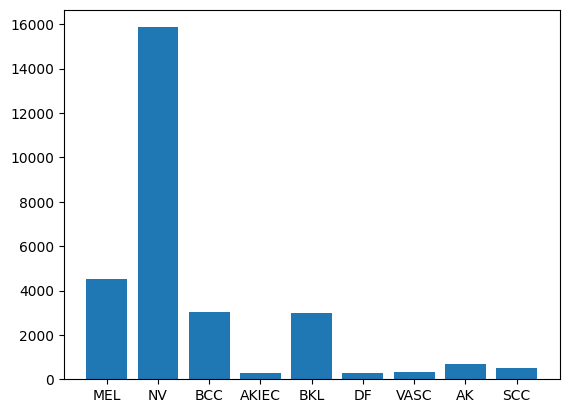

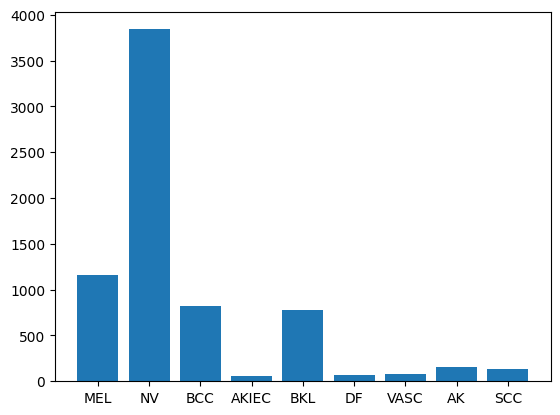

{'MEL': 4500, 'NV': 15860, 'BCC': 3031, 'AKIEC': 273, 'BKL': 2972, 'DF': 283, 'VASC': 316, 'AK': 707, 'SCC': 490}
{'MEL': 1156, 'NV': 3843, 'BCC': 821, 'AKIEC': 62, 'BKL': 773, 'DF': 72, 'VASC': 82, 'AK': 160, 'SCC': 138}


In [25]:
train_distribution = get_distribution(dls.train.items, True)
valid_distribution = get_distribution(dls.valid.items, True)
print(train_distribution)
print(valid_distribution)

In [ ]:
#weights = get_weights(gt) #TODO: convert into pytorch tensor

model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(weight=weights), metrics=accuracy, cbs=ShowGraphCallback())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.194309,1.206962,0.578725,02:39
1,1.085954,1.071913,0.624033,02:37
2,1.027455,1.072655,0.606304,02:40
3,0.947579,1.136471,0.620515,02:39
4,0.917734,0.888091,0.679612,02:40


In [ ]:
# an example of normalization calculated on a batch of images
# (because we aren't using normalization yet, you'll see the mean and standard deviation are not very close to
# 0 and 1 respectively)
x, y = dls.one_batch()

x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

In [11]:
def get_dls(batch_size, image_size):
  dls = ImageDataLoaders.from_df(
    gt,
    path="/content/train/ISIC2018_Task3_Training_Input",
    csv_fname="/content/train/ISIC2018_Task3_Training_Input/Training_GroundTruth_Merged.csv",
    label_col='dx',
    item_tfms = Resize(460),
    batch_tfms = [*aug_transforms(size=image_size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)],
    bs=batch_size
  )
  return dls

In [ ]:
dls = get_dls(64, 224)

# an example of normalization calculated on a batch of images
# (because we are using normalization now, the mean and standard deviation are very close to 0 and 1 respectively)
x, y = dls.one_batch()
print(x.mean(dim=[0,2,3]), x.std(dim=[0,2,3]))

# does this normalization improve our model? Let's see ...
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=ShowGraphCallback())
learn.fit_one_cycle(5, 3e-3)

## Progressive Resizing

epoch,train_loss,valid_loss,accuracy,time
0,1.183243,1.272132,0.561137,02:26
1,1.039678,1.024477,0.622203,02:24
2,0.971426,0.957888,0.656677,02:25
3,0.910715,0.929538,0.662305,02:26


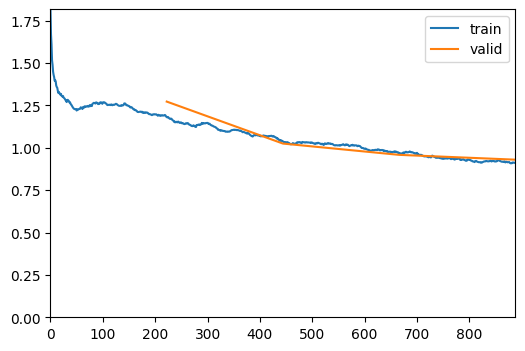

epoch,train_loss,valid_loss,accuracy,time
0,0.982644,0.963432,0.663290,02:38


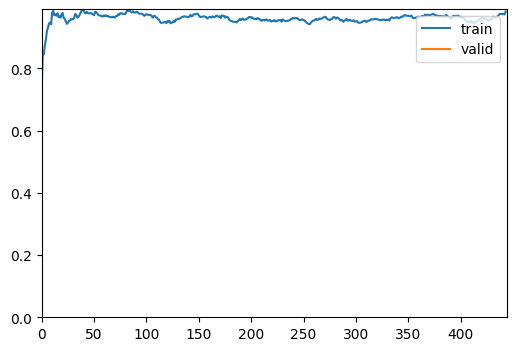

epoch,train_loss,valid_loss,accuracy,time
0,0.909650,0.895994,0.679471,02:34
1,0.913021,0.884901,0.680597,02:37
2,0.873153,0.868691,0.692557,02:36
3,0.832425,0.821740,0.707471,02:36
4,0.832873,0.806477,0.709019,02:35


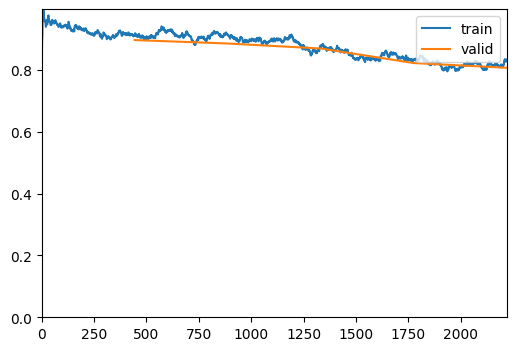

In [13]:
model = xresnet50(pretrained=False)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.AdaptiveMaxPool1d(128),
    nn.Linear(128, 9)
)

dls = get_dls(128,128)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(weight=weights), metrics=accuracy, cbs=ShowGraphCallback())
learn.fit_one_cycle(4, 3e-3)

# simply replace the `Learner.dls` with new `DataLoaders` and continue traning.
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

## TTA

In [ ]:
# you can pass any `DataLoaders` to `tta()` (by default it uses your validation `DataLoader`)
preds, targs = learn.tta()
accuracy(preds, targs).item()

## MixUp

In [ ]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=MixUp)
learn.fit_one_cycle(5, 3e-3)

## Label Smoothing

In [ ]:
model = xresnet50()
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

## Model Testing